In [2]:
from google.colab import files
  

uploaded = files.upload()


Saving mydata.csv to mydata (1).csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#pad_sequences used to pad those data which are not too long because it's a text data and some text could be just 100 words lets suppose
#we are taking a text of length 700 
#deep learnig model takes only constant length input. its not like that you have designed a system 700 length of input.you cannot give 500,600 or 
# more than 700 . its always need a fixed length of input.
from tensorflow.keras.models import Sequential
#in sequential model we will be feeding our layers.
from tensorflow.keras.layers import Dense, Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classifiaction_report,accuracy_score


In [6]:
data=pd.read_csv("mydata.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31428 entries, 0 to 31427
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       31428 non-null  int64 
 1   title    31428 non-null  object
 2   text     31428 non-null  object
 3   subject  31428 non-null  object
 4   date     31428 non-null  object
 5   label    31428 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


In [7]:
data['subject'].value_counts()

politicsNews       7863
worldnews          7088
News               6378
politics           4832
left-news          3096
Government News    1089
US_News             546
Middle-east         536
Name: subject, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


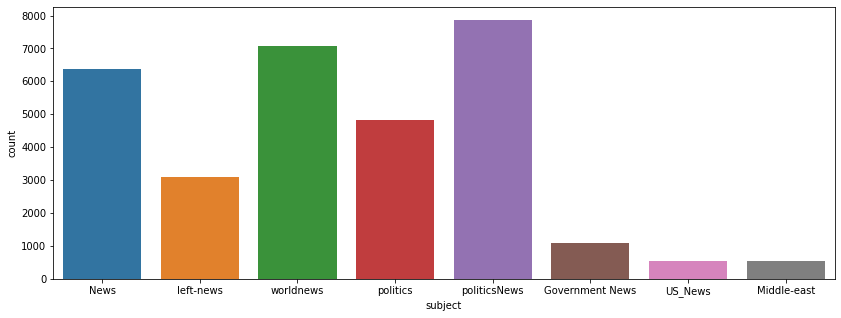

In [8]:
plt.figure(figsize=(14,5))
sns.countplot('subject',data=data)

Word Cloud

In [9]:
#data['text'].tolist()
# to feed a data into wordcloud we need a sigle text data that's when the list we need to merge into a sigle text data.because if we check the 
type
text=' '.join(data['text'].tolist())


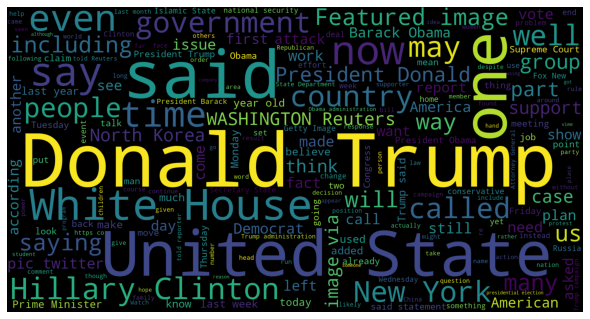

In [ ]:
wordcloud=WordCloud(width=1700,height=900).generate(text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)


Cleaning the data
- removing reuters or twitter tweet information from the text.
- text can be splitted only at once at *-* which is always present after the source of the publication , this gives use publication part and text part
- if we do not get a text part this means publication details was not given for that record.
-the twitter tweets always have the same source , a long text of max 259 characters.
 

In [10]:
#data.sample(5)
# we are going to create a list of indexes that do not have the publication information.so break the text with the hyphen ('-') then after if the 
# reuters info is not there . we will not get the publication details.

# #here we split using hyphen
# if there is a hyphen then it will check that the particular news comes from the tweet or not. as we know that the tweet data which contains
#less than 260 words . we use assert to find length of the data.
unknown_publishers=[]
for index,row in enumerate(data.text.values):
  try:
    record = row.split('-',maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)
    

In [11]:
#unknown_publishers #here we get how may unknown publishers are there . the length of the indices. 
len(unknown_publishers) # 11092 are unknown publishers if we remove space before and after hyphen but we will keep as it is.

14456

In [12]:
# so we will get the real data 
data.iloc[unknown_publishers].text

0        Paul Manafort, the chair of Donald Trump s cam...
1        How very  charitable  of the Lutheran and Cath...
2        In case you ve been living under a rock for yo...
5        Could this be a little bit of KARMA coming bac...
7         I would hope that a wise Latina woman with th...
                               ...                        
31417    It s no secret Americans have been demonstrati...
31421    Donald Trump doesn t have much foreign policy ...
31422    Tune in to the Alternate Current Radio Network...
31423    A huge rally of 10,000 Chicagoans didn t get t...
31425    Today, I would hate to be a Republican strateg...
Name: text, Length: 14456, dtype: object

In [13]:
#since we have our publishers information. now we have publisher index too. 
#we will create new columnn in which we will put publisher information and for fewer rows  which also needs to be handled.
publisher=[]
tmp_text=[]

for index,row in enumerate(data.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    continue
  else:
    record= row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())


In [14]:
data['publisher']=publisher
data['text']=tmp_text

In [15]:
#data.head()
data.shape

(31428, 7)

In [16]:
data['text']=data['title']+ ' '+data['text']

In [17]:
data['text']=data['text'].apply(lambda x:str(x).lower())

In [18]:
data.columns

Index(['Id', 'title', 'text', 'subject', 'date', 'label', 'publisher'], dtype='object')

Pre Processing text

In [19]:
data = data[["text","label"]]
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31428 entries, 0 to 31427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    31428 non-null  object
 1   label   31428 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 491.2+ KB


In [ ]:
!pip  install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textlob==0.15.3

     |████████████████████████████████| 12.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
ERROR: Could not find a version that satisfies the requirement textlob==0.15.3 (from versions: none)
ERROR: No matching distribution found for textlob==0.15.3


In [ ]:
data.head()

,text,label
0,watch: paul manafort gets destroyed on cnn fo...,1
1,refugee business is cash cow for lutheran char...,1
2,trump’s excuse for all his sexist statements ...,1
3,'jihadi gran' gets 10 years after joining son ...,0
4,new czech government to seek confidence vote o...,0


In [20]:
import gensim

In [21]:
y= data["label"].values

In [22]:
X =[d .split() for d in data['text'].tolist()]
type(X[0])

list

In [23]:
DIM= 100
#which meand each of this word will be converted into a squence of 100 vectors.
w2v_model=gensim.models.Word2Vec(sentences=X,size=DIM,window=10,min_count=1)

In [24]:
len(w2v_model.wv.vocab)
w2v_model.wv.most_similar('modi')

[('narendra', 0.730835497379303),
 ('macron,', 0.6901295185089111),
 ('venezuela', 0.6832204461097717),
 ('thailand', 0.6795903444290161),
 ('india', 0.6789911985397339),
 ('peru', 0.6766796708106995),
 ('abe', 0.6745983362197876),
 ('tokyo', 0.6711505651473999),
 ('zimbabwe', 0.6665321588516235),
 ('cambodia', 0.6615892052650452)]

In [25]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)

In [26]:
X=tokenizer.texts_to_sequences(X)
#this is a sequence number for each word and to access that word this number can be used.
#tokenizer.word_index

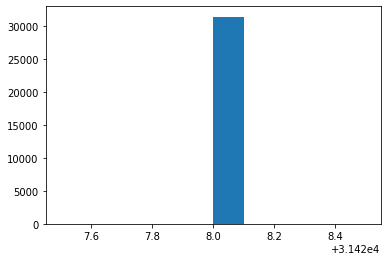

In [ ]:
plt.hist([len(X) for x in X],bins=10)
plt.show()

In [27]:
nos=np.array([len(X) for x in X])
len(nos[nos>1000])

31428

In [28]:
maxlen=1000
X=pad_sequences(X,maxlen=maxlen)
len(X[0])

1000

In [29]:
vocab_size= len(tokenizer.word_index) +1
vocab=tokenizer.word_index
len(tokenizer.word_index)

312858

In [30]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size,DIM))
  
  for word , i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [31]:
embedding_vectors = get_weight_matrix(w2v_model)

In [32]:
embedding_vectors.shape

(312859, 100)

In [33]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional


In [34]:
#model=Sequential()
#model.add(Embedding(vocab_size,output_dim=DIM,weights=[embedding_vectors],input_length=maxlen,trainable=False))
#model.add(LSTM(units=128))
#model.add(Dense(1,activation='sigmoid'))
#model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

#model = Sequential()
#model.add(Embedding(500, 120, input_length = X.shape[1]))
#model.add(SpatialDropout1D(0.4))
#model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
#model.add(Dense(2,activation='sigmoid'))
#model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
#print(model.summary())



model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         40045952  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 40,144,897
Trainable params: 40,144,897
Non-trainable params: 0
_________________________________________________________________


In [36]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [37]:
#model.fit(X_train,y_train,validation_split=0.3,epochs=6)
#batch_size=32
#model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

history=model.fit(X_train, y_train,
           batch_size=128,
           epochs=12,
          validation_data=[X_test, y_test])
print(history.history['loss'])
print(history.history['accuracy'])


Epoch 1/12
185/185 [==============================] - 27s 123ms/step - loss: 0.2049 - accuracy: 0.9195 - val_loss: 0.1103 - val_accuracy: 0.9616
Epoch 2/12
185/185 [==============================] - 22s 120ms/step - loss: 0.0405 - accuracy: 0.9906 - val_loss: 0.0440 - val_accuracy: 0.9855
Epoch 3/12
185/185 [==============================] - 22s 121ms/step - loss: 0.0207 - accuracy: 0.9944 - val_loss: 0.0403 - val_accuracy: 0.9884
Epoch 4/12
185/185 [==============================] - 22s 122ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0472 - val_accuracy: 0.9884
Epoch 5/12
185/185 [==============================] - 23s 122ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0582 - val_accuracy: 0.9849
Epoch 6/12
185/185 [==============================] - 22s 122ms/step - loss: 0.0848 - accuracy: 0.9849 - val_loss: 0.0494 - val_accuracy: 0.9870
Epoch 7/12
185/185 [==============================] - 23s 123ms/step - loss: 0.0075 - accuracy: 0.9987 - val_loss: 0.0459 - val_ac

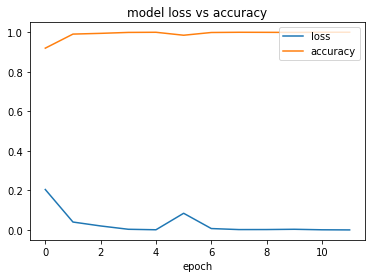

In [40]:
#y_pred=(history.predict(X_test)>=0.5).astype(int)
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show() 


In [ ]:
#from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

#classification_report(y_test,y_pred)
